In [1]:
from pgmpy.models import BayesianModel
from pgmpy.factors.discrete import TabularCPD
import numpy as np
from utils import *
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
PER_UNIT_GDP = 'Per unit GDP'
ROAD_DENSITY = 'Road density'
POPULATION_DENSITY = 'Population density'
ELEVATION = 'Elevation'
SLOPE = 'Slope'
RAINFALL_FREQUENCY = 'Rainfall frequency'
RIVER_DENSITY = 'River density'
RAINFALL_AMOUNT = 'Rainfall amount'
FLOOD = 'Flood'

In [4]:
# population density
# popolazione 

In [5]:
values_dictionary = {
    PER_UNIT_GDP: [
        [0.3], 
        [0.63], 
        [0.07]
    ],
    POPULATION_DENSITY: [
        [0.7, 0.3, 0.05],
        [0.2, 0.55, 0.25],
        [0.1, 0.15, 0.7],
    ],
    ROAD_DENSITY: [
        [0.8, 0.7, 0.1, 0.6, 0.4, 0.1, 0.1, 0.05, 0.01],
        [0.19, 0.25, 0.35, 0.3, 0.5, 0.25, 0.25, 0.2, 0.15],
        [0.01, 0.05, 0.55, 0.1, 0.1, 0.65, 0.65, 0.75, 0.84]
    ],
    ELEVATION: [
        [0.15],
        [0.1], 
        [0.75]
    ],
    SLOPE: [
        [0.75, 0.6, 0.05], 
        [0.25, 0.4, 0.95]
    ],
    RAINFALL_FREQUENCY: [
        [0.3], 
        [0.6], 
        [0.1]
    ],
    RIVER_DENSITY: [
        [0.4], 
        [0.6]
    ],
    RAINFALL_AMOUNT: [
        [0.7, 0.5, 0.55, 0.3, 0.1, 0.01],
        [0.2, 0.25, 0.3, 0.4, 0.3, 0.04],
        [0.1, 0.25, 0.15, 0.3, 0.6, 0.95]
    ],
    FLOOD: [
        [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
        [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2]
    ],
}

# FLOOD, ROAD_DENSITY, SLOPE, RAINFALL_AMOUNT

In [6]:
state_names_dictionary = {
    PER_UNIT_GDP: ['High', 'Medium', 'Low'],
    POPULATION_DENSITY: ['Dense', 'Medium', 'Sparse'],
    ROAD_DENSITY: ['Dense', 'Medium', 'Sparse'],
    ELEVATION: ['High', 'Medium', 'Low'],
    SLOPE: ['Steep', 'Flat'],
    RAINFALL_FREQUENCY: ['Frequent', 'Medium', 'Rare'],
    RIVER_DENSITY: ['Dense', 'Sparse'],
    RAINFALL_AMOUNT: ['Huge', 'Medium', 'Little'],
    FLOOD: ['Yes', 'No']
}

In [7]:
edges = [
    (PER_UNIT_GDP, ROAD_DENSITY), 
    (PER_UNIT_GDP, POPULATION_DENSITY), 
    (POPULATION_DENSITY, ROAD_DENSITY),
    (ROAD_DENSITY, FLOOD),
    (ELEVATION, SLOPE),
    (SLOPE, FLOOD),
    (RAINFALL_FREQUENCY, RAINFALL_AMOUNT),
    (RIVER_DENSITY, RAINFALL_AMOUNT),
    (RAINFALL_AMOUNT, FLOOD)
]

In [8]:
evidence_dictionary = {
    PER_UNIT_GDP: None,
    POPULATION_DENSITY: [PER_UNIT_GDP],
    ROAD_DENSITY: [PER_UNIT_GDP, POPULATION_DENSITY],
    ELEVATION: None,
    SLOPE: [ELEVATION],
    RAINFALL_FREQUENCY: None,
    RIVER_DENSITY: None,
    RAINFALL_AMOUNT: [RAINFALL_FREQUENCY, RIVER_DENSITY],
    FLOOD: [ROAD_DENSITY, SLOPE, RAINFALL_AMOUNT]
}

In [9]:
# Defining the model structure. We can define the network by just passing a list of edges.
model = BayesianModel(edges)

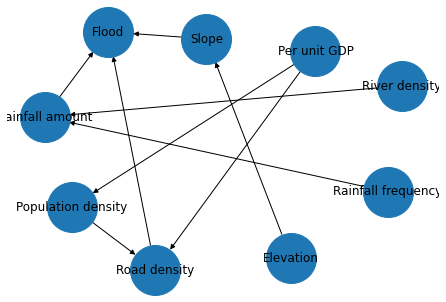

In [10]:
nx.draw(model, node_size = 2500, with_labels = True)
plt.show()

In [11]:
# ToDo: an idea can be to set the evidence, its cardinality and the state_names programmatically, 
# or even define these tables in a for loop

cpd_per_unit_gdp = TabularCPD(
    variable = PER_UNIT_GDP, 
    variable_card = len(state_names_dictionary[PER_UNIT_GDP]), 
    values = values_dictionary[PER_UNIT_GDP],
    state_names = get_state_names(PER_UNIT_GDP, state_names_dictionary, evidence_dictionary)
)

cpd_population_density = TabularCPD(
    variable = POPULATION_DENSITY, 
    variable_card = len(state_names_dictionary[POPULATION_DENSITY]), 
    values = values_dictionary[POPULATION_DENSITY],
    evidence = evidence_dictionary[POPULATION_DENSITY],
    evidence_card = get_evidence_card(POPULATION_DENSITY, state_names_dictionary, evidence_dictionary),
    state_names = get_state_names(POPULATION_DENSITY, state_names_dictionary, evidence_dictionary)
)

cpd_road_density = TabularCPD(
    variable = ROAD_DENSITY, 
    variable_card = len(state_names_dictionary[ROAD_DENSITY]), 
    values = values_dictionary[ROAD_DENSITY],
    evidence = evidence_dictionary[ROAD_DENSITY],
    evidence_card = get_evidence_card(ROAD_DENSITY, state_names_dictionary, evidence_dictionary),
    state_names = get_state_names(ROAD_DENSITY, state_names_dictionary, evidence_dictionary)
)

cpd_elevation = TabularCPD(
    variable = ELEVATION, 
    variable_card = len(state_names_dictionary[ELEVATION]), 
    values = values_dictionary[ELEVATION],
    state_names = get_state_names(ELEVATION, state_names_dictionary, evidence_dictionary)
)

cpd_slope = TabularCPD(
    variable = SLOPE, 
    variable_card = len(state_names_dictionary[SLOPE]), 
    values = values_dictionary[SLOPE],
    evidence = evidence_dictionary[SLOPE],
    evidence_card = get_evidence_card(SLOPE, state_names_dictionary, evidence_dictionary),
    state_names = get_state_names(SLOPE, state_names_dictionary, evidence_dictionary)
)

cpd_rainfall_frequency = TabularCPD(
    variable = RAINFALL_FREQUENCY, 
    variable_card = len(state_names_dictionary[RAINFALL_FREQUENCY]), 
    values = values_dictionary[RAINFALL_FREQUENCY],
    state_names = get_state_names(RAINFALL_FREQUENCY, state_names_dictionary, evidence_dictionary)
)

cpd_river_density = TabularCPD(
    variable = RIVER_DENSITY, 
    variable_card = len(state_names_dictionary[RIVER_DENSITY]), 
    values = values_dictionary[RIVER_DENSITY],
    state_names = get_state_names(RIVER_DENSITY, state_names_dictionary, evidence_dictionary)
)

cpd_rainfall_amount = TabularCPD(
    variable = RAINFALL_AMOUNT, 
    variable_card = len(state_names_dictionary[RAINFALL_AMOUNT]), 
    values = values_dictionary[RAINFALL_AMOUNT],
    evidence = evidence_dictionary[RAINFALL_AMOUNT],
    evidence_card = get_evidence_card(RAINFALL_AMOUNT, state_names_dictionary, evidence_dictionary),
    state_names = get_state_names(RAINFALL_AMOUNT, state_names_dictionary, evidence_dictionary)
)

cpd_flood = TabularCPD(
    variable = FLOOD, 
    variable_card = len(state_names_dictionary[FLOOD]), 
    values = values_dictionary[FLOOD],
    evidence = evidence_dictionary[FLOOD],
    evidence_card = get_evidence_card(FLOOD, state_names_dictionary, evidence_dictionary),
    state_names = get_state_names(FLOOD, state_names_dictionary, evidence_dictionary)
)

In [12]:
cpd_to_pandas(cpd_per_unit_gdp)

,
Per unit GDP(High),0.30
Per unit GDP(Medium),0.63
Per unit GDP(Low),0.07


In [13]:
cpd_to_pandas(cpd_population_density)

,Per unit GDP(High),Per unit GDP(Medium),Per unit GDP(Low)
Population density(Dense),0.7,0.30,0.05
Population density(Medium),0.2,0.55,0.25
Population density(Sparse),0.1,0.15,0.70


In [14]:
cpd_to_pandas(cpd_road_density)

Per unit GDP(High)          \
                        Population density(Dense)    
 Road density(Dense)                          0.80   
 Road density(Medium)                         0.19   
 Road density(Sparse)                         0.01   

                        Per unit GDP(High)           \
                        Population density(Medium)    
 Road density(Dense)                           0.70   
 Road density(Medium)                          0.25   
 Road density(Sparse)                          0.05   

                                                     \
                        Population density(Sparse)    
 Road density(Dense)                           0.10   
 Road density(Medium)                          0.35   
 Road density(Sparse)                          0.55   

                        Per unit GDP(Medium)        \
                        Population density(Dense)    
 Road density(Dense)                           0.6   
 Road density(Medium)                          0.3   
 Road density(Sparse)                          0.1   

                        Per unit GDP(Medium)         \
                        Population density(Medium)    
 Road density(Dense)                            0.4   
 Road density(Medium)                           0.5   
 Road density(Sparse)                           0.1   

                                                     \
                        Population density(Sparse)    
 Road density(Dense)                           0.10   
 Road density(Medium)                          0.25   
 Road density(Sparse)                          0.65   

                        Per unit GDP(Low)           \
                        Population density(Dense)    
 Road density(Dense)                          0.10   
 Road density(Medium)                         0.25   
 Road density(Sparse)                         0.65   

                        Per unit GDP(Low)            \
                        Population density(Medium)    
 Road density(Dense)                           0.05   
 Road density(Medium)                          0.20   
 Road density(Sparse)                          0.75   

                                                     
                        Population density(Sparse)   
 Road density(Dense)                           0.01  
 Road density(Medium)                          0.15  
 Road density(Sparse)                          0.84

In [15]:
cpd_to_pandas(cpd_elevation)

,
Elevation(High),0.15
Elevation(Medium),0.10
Elevation(Low),0.75


In [16]:
cpd_to_pandas(cpd_slope)

,Elevation(High),Elevation(Medium),Elevation(Low)
Slope(Steep),0.75,0.6,0.05
Slope(Flat),0.25,0.4,0.95


In [17]:
cpd_to_pandas(cpd_rainfall_frequency)

,
Rainfall frequency(Frequent),0.3
Rainfall frequency(Medium),0.6
Rainfall frequency(Rare),0.1


In [18]:
cpd_to_pandas(cpd_river_density)

,
River density(Dense),0.4
River density(Sparse),0.6


In [19]:
cpd_to_pandas(cpd_rainfall_amount)

Rainfall frequency(Frequent)   \
                           River density(Dense)            
 Rainfall amount(Huge)                               0.7   
 Rainfall amount(Medium)                             0.2   
 Rainfall amount(Little)                             0.1   

                                                          \
                           River density(Sparse)           
 Rainfall amount(Huge)                              0.50   
 Rainfall amount(Medium)                            0.25   
 Rainfall amount(Little)                            0.25   

                           Rainfall frequency(Medium)   \
                           River density(Dense)          
 Rainfall amount(Huge)                            0.55   
 Rainfall amount(Medium)                          0.30   
 Rainfall amount(Little)                          0.15   

                                                        \
                           River density(Sparse)         
 Rainfall amount(Huge)                             0.3   
 Rainfall amount(Medium)                           0.4   
 Rainfall amount(Little)                           0.3   

                           Rainfall frequency(Rare)   \
                           River density(Dense)        
 Rainfall amount(Huge)                           0.1   
 Rainfall amount(Medium)                         0.3   
 Rainfall amount(Little)                         0.6   

                                                      
                           River density(Sparse)      
 Rainfall amount(Huge)                          0.01  
 Rainfall amount(Medium)                        0.04  
 Rainfall amount(Little)                        0.95

In [20]:
cpd_to_pandas(cpd_flood)

Road density(Dense)     Road density(Dense)       \
                   Slope(Steep)            Slope(Steep)               
                   Rainfall amount(Huge)   Rainfall amount(Medium)    
 Flood(Yes)                           0.1                       0.1   
 Flood(No)                            0.2                       0.2   

                                             Road density(Dense)     \
                                             Slope(Flat)              
                   Rainfall amount(Little)   Rainfall amount(Huge)    
 Flood(Yes)                             0.1                     0.1   
 Flood(No)                              0.2                     0.2   

                   Road density(Dense)                                 \
                   Slope(Flat)                                          
                   Rainfall amount(Medium)   Rainfall amount(Little)    
 Flood(Yes)                             0.1                       0.1   
 Flood(No)                              0.2                       0.2   

                   Road density(Medium)    Road density(Medium)      \
                   Slope(Steep)            Slope(Steep)               
                   Rainfall amount(Huge)   Rainfall amount(Medium)    
 Flood(Yes)                           0.1                       0.1   
 Flood(No)                            0.2                       0.2   

                                             Road density(Medium)    \
                                             Slope(Flat)              
                   Rainfall amount(Little)   Rainfall amount(Huge)    
 Flood(Yes)                             0.1                     0.1   
 Flood(No)                              0.2                     0.2   

                   Road density(Medium)                                \
                   Slope(Flat)                                          
                   Rainfall amount(Medium)   Rainfall amount(Little)    
 Flood(Yes)                             0.1                       0.1   
 Flood(No)                              0.2                       0.2   

                   Road density(Sparse)    Road density(Sparse)      \
                   Slope(Steep)            Slope(Steep)               
                   Rainfall amount(Huge)   Rainfall amount(Medium)    
 Flood(Yes)                           0.1                       0.1   
 Flood(No)                            0.2                       0.2   

                                             Road density(Sparse)    \
                                             Slope(Flat)              
                   Rainfall amount(Little)   Rainfall amount(Huge)    
 Flood(Yes)                             0.1                     0.1   
 Flood(No)                              0.2                     0.2   

                   Road density(Sparse)                                
                   Slope(Flat)                                         
                   Rainfall amount(Medium)   Rainfall amount(Little)   
 Flood(Yes)                             0.1                       0.1  
 Flood(No)                              0.2                       0.2